# Sentiment analysis of Yelp user review data

## Overview

Social data like customer reviews on Yelp.com provides important, real-time insights on consumer feelings. The details of restaurants like name, price, rating, reviews are available on Yelp. Here is the question I would like to dig into is that whether ratings alone is enough to give the correct information about a restaurant in Downtown Detroit. Probably a sentiment analysis would give us a better picture. Join with me to figuring it out!

## Web Scraping with BeautifulSoup

I scraped ~800 restaurants info in Downtown Detroit in the following two steps. As for customers' reviews, only the top 100 search result were scraped. Python code used is available in the current directory.

step1_scraping.py: restaurant name, rating, price, number of reviews, category >> yelp_downtowndtw.csv 

step2_scraping.py: restaurant name, customer reviews >> yelp_downtowndtw_reviews.csv 

## Exploratory Data Analysis

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load data from cvs file to pandas data frame
data=pd.read_csv("yelp_downtowndtw.csv",sep='\t')
data.head(5)

,Name,category,price,rating,review_count
0,Wright & Company,"Gastropubs,American (New),Tapas/Small Plates",$$,4.0,609.0
1,Republic,American (New),$$$,4.0,349.0
2,The Greek,"Greek,Mediterranean",$$,3.0,5.0
3,Parc,"American (New),Bars,Breakfast & Brunch",$$$,4.0,187.0
4,Standby,"American (New),Cocktail Bars",$$,4.5,236.0


#### 1. The distribution of the ratings is as follows:

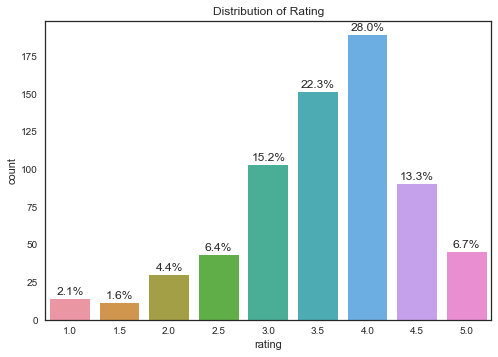

In [3]:
rating_col=data["rating"].dropna()
sns.set(style="white",palette="muted",color_codes=True)
ax=sns.countplot(rating_col)
ax.set_title("Distribution of Rating")
total = float(len(rating_col)) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}'.format(height/total*100)+"%",
            ha="center") 

Most of the restaurants (28%) in Downtown Detorit have a rating of 4.

#### 2. The distribution of the number of reviews is as follows:

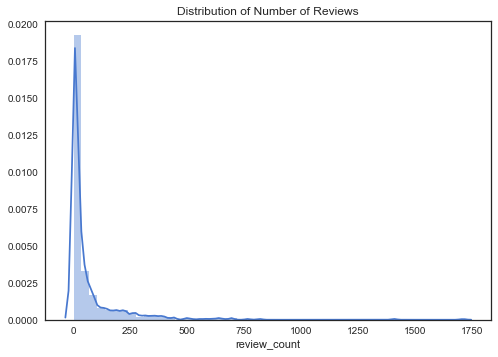

In [4]:
reviewnum=data["review_count"].dropna()
sns.set(style="white",palette="muted",color_codes=True)
ax=sns.distplot(reviewnum)
ax.set_title("Distribution of Number of Reviews")

The distribution shows that the majority of the restaurant reviews range from 0 to 250.

#### 3. The distribution of the price is as follows:

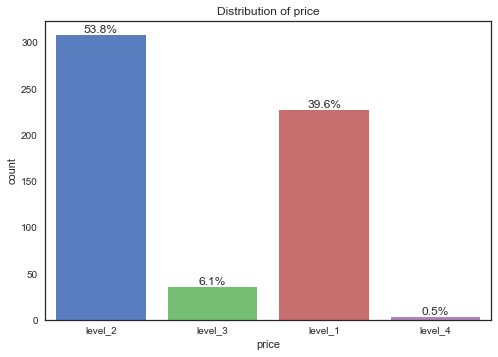

In [5]:
price_map={"$":"level_1","$$":"level_2","$$$":"level_3","$$$$":"level_4"}
price=data.price.map(price_map).dropna()
sns.set(style="white",palette="muted",color_codes=True)
ax=sns.countplot(price)
ax.set_title("Distribution of price")
total = float(len(price)) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}'.format(height/total*100)+"%",
            ha="center") 

More than half of the restaurants in Downtown Detorit have a price level of "$$".

#### 4. Word cloud  plot for restaurant categories

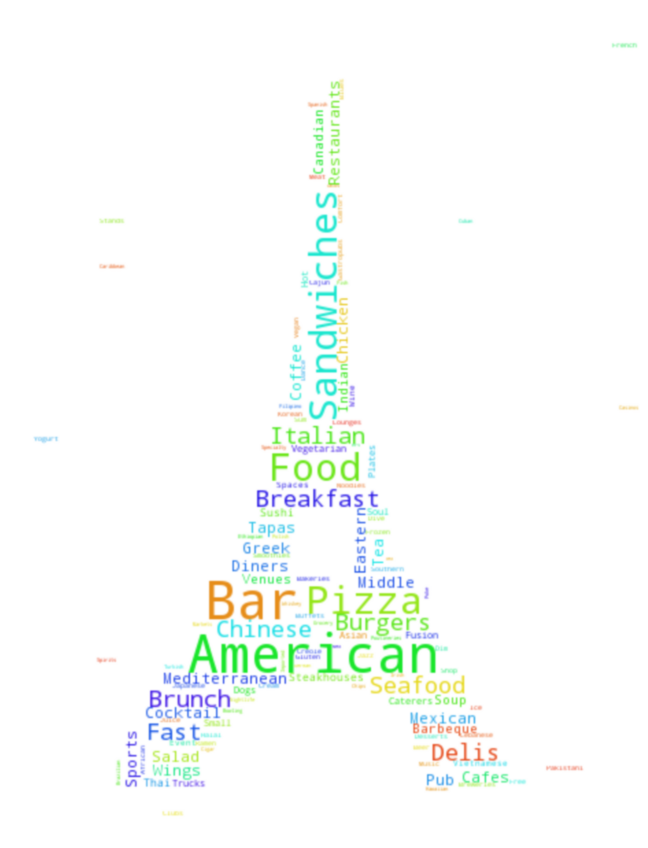

In [6]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Read the whole text.
text = ','.join(data.category)
# read the mask image
# taken from
# http://www.stencilry.org/stencils/miscellaneous/Eiffel-Tower-7.jpg
tower_mask = np.array(Image.open("tower_image.jpg"))
stopwords = set(STOPWORDS)
stopwords.add("New")
stopwords.add("Traditional")
wc = WordCloud(background_color="white", max_words=500, mask=tower_mask,stopwords=stopwords)
# generate word cloud
wc.generate(text)
# show
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bicubic')
plt.axis("off")
plt.figure()

The common categories of restaurant in Downtown Detroit are American, Bar, Breakfast&Brunch and Bar.

## Sentiment Analysis using Natural Language Toolkit.

Sentiment analysis was performed using the Natural Language Toolkit. Vader SentimentAnalyzer was used to obtain the polarity scores for the reviews of restaurants. The code for sentiment analysis is as follows:

In [7]:
import csv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
sid = SentimentIntensityAnalyzer() 

In [8]:
file=open("yelp_downtowndtw_reviews.csv")
lines=file.readlines()
file.close()

In [9]:
name=[]
reviews=[]
target=open("output1.csv",'w')
target.write("Name")
target.write(",")
target.write("Rating")
target.write(",")
target.write("Reviews_count")
target.write(",")
target.write("compound")
target.write(",")
target.write("positive")
target.write(",")
target.write("neutral")
target.write(",")
target.write("negative")
target.write("\n")

for line in lines[1:]:
    row=line.split('\t')
    name.append(row[0])
    line_list=row[1].split('|')
    pos_rate = []
    neu_rate = []
    neg_rate = []
    compound_rate = []
        
    for sentence in line_list:
        ss = sid.polarity_scores(sentence)
        compound_rate.append(ss['compound']) 
        pos_rate.append(ss['pos'])
        neu_rate.append(ss['neu'])
        neg_rate.append(ss['neg'])
        
    compound = np.mean(compound_rate)
    pos = np.mean(pos_rate)
    neg = np.mean(neg_rate)
    neu = np.mean(neu_rate)
            
    target.write(row[0])
    target.write(",")
    target.write(str(float(data.loc[data.Name==row[0]]['rating'])))
    target.write(",")
    target.write(str(int(data.loc[data.Name==row[0]]['review_count'])))
    target.write(",")    
    target.write(str(compound))
    target.write(",")
    target.write(str(pos))
    target.write(",")
    target.write(str(neu))
    target.write(",")
    target.write(str(neg))
    target.write("\n")
    
    #print(compound,pos,neg,neu)

target.close()   

Load the data from output1.csv and plot a diagonal correlation matrix.

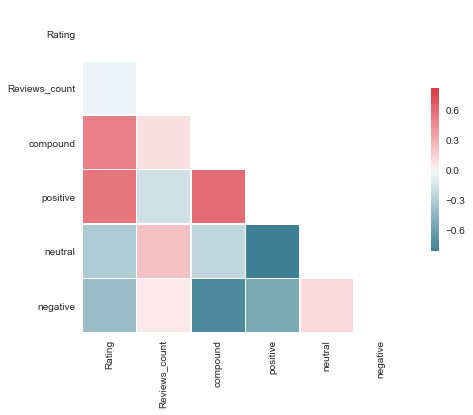

In [10]:
score_df=pd.read_csv("output1.csv")
sns.set(style='white')
corr=score_df[score_df.columns[1:]].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It is found that rating is positively correlated with both the compound and positive scores and negatively correlated with both neutral and negative scores. Overall the restaurant ratings on Yelp.com for the area of Downtown Detroit can reasonably represent the customers' opinion of the restaurant as is expressed in the reviews. 
However, there is no clear connection between review count and rating.